In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

df = pd.read_csv("csvs\customer_segregation.csv")
df.head()

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Chris\AppData\Local\Temp\ipykernel_16720\3141693589.py:7: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("csvs\customer_segregation.csv")


,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0


In [3]:
df["term_deposit_subscribed"].value_counts()

term_deposit_subscribed
0    28253
1     3394
Name: count, dtype: int64

In [4]:
df.drop(columns=["id"], inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for column in df.select_dtypes(include=["object"]).columns:
    df[column] = le.fit_transform(df[column])


<Axes: >

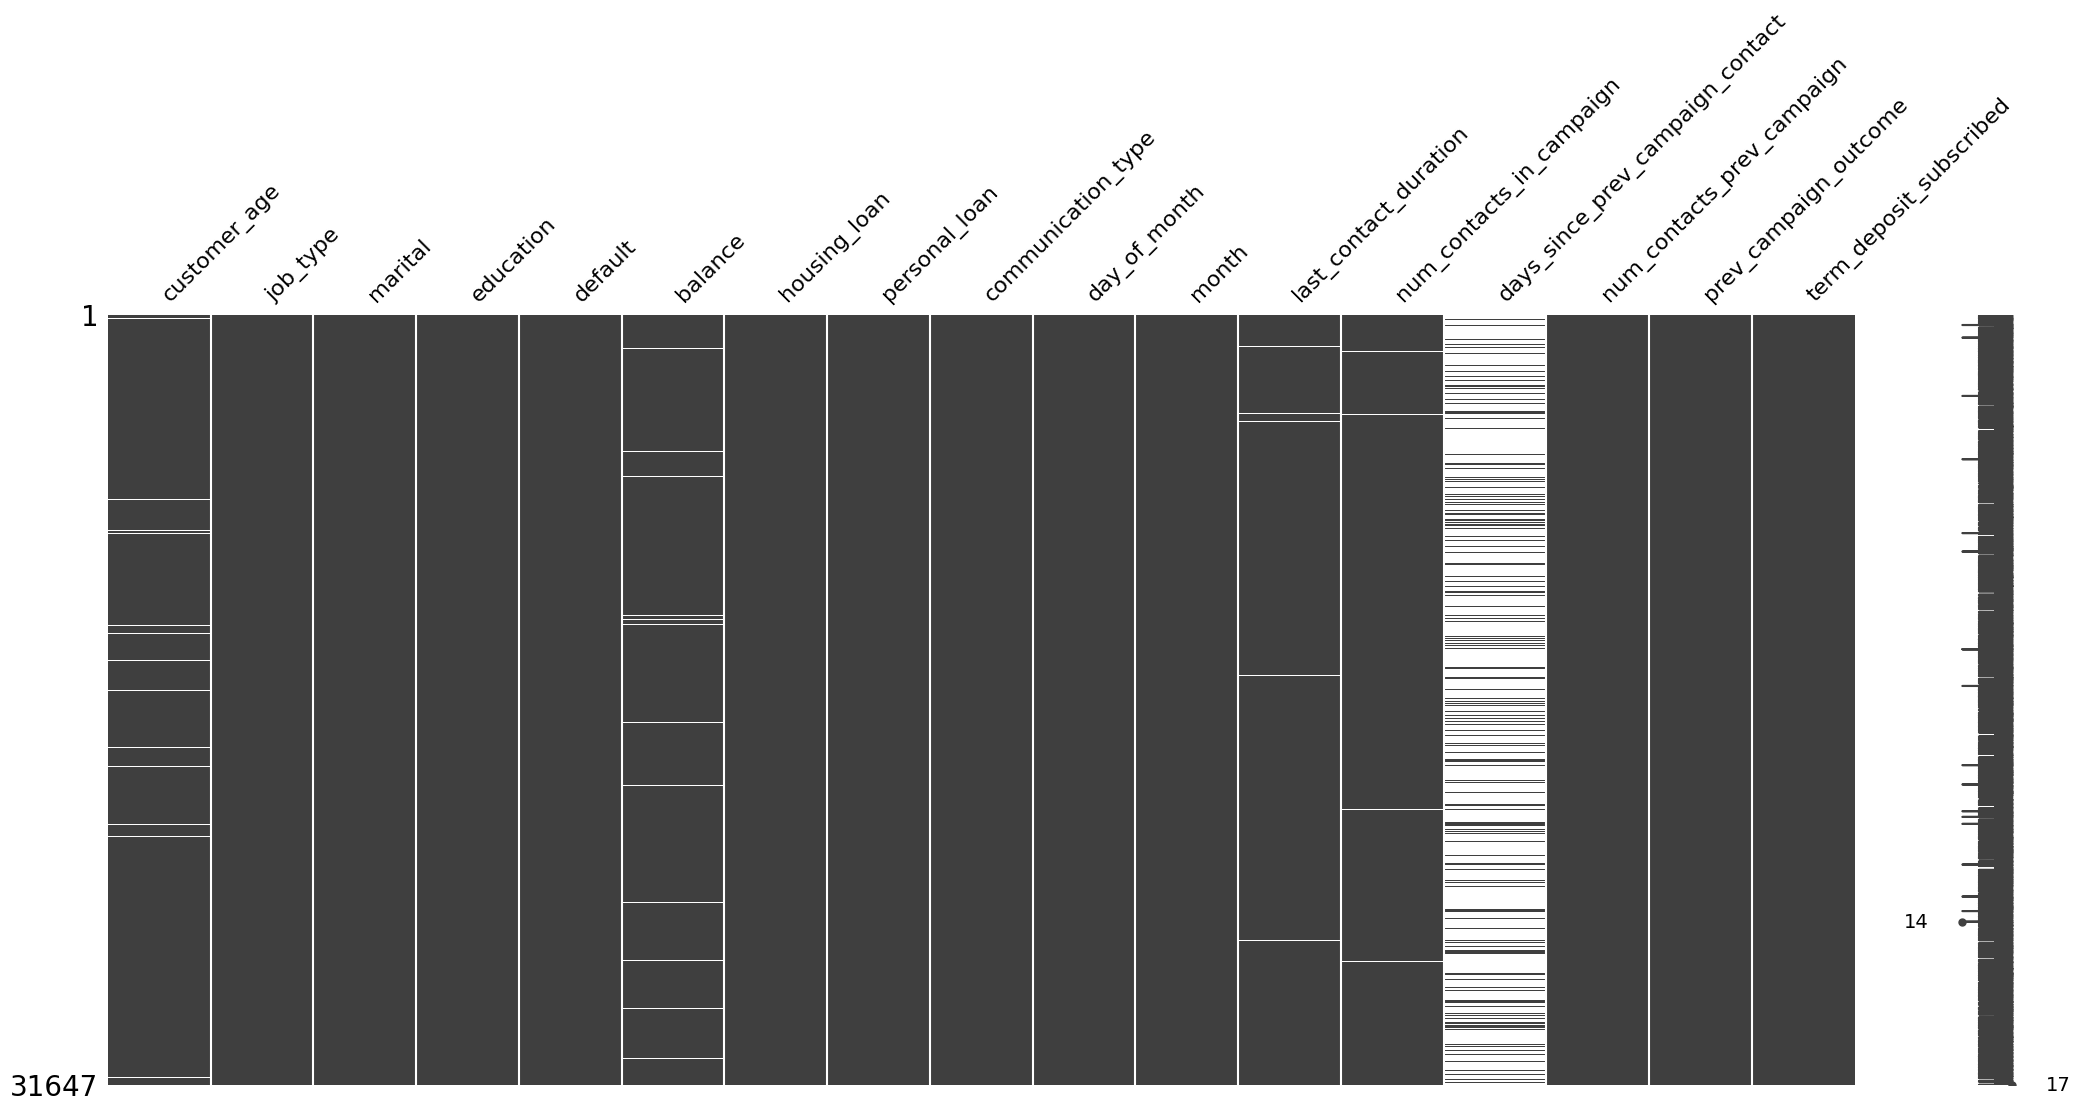

In [6]:
import missingno as msno

msno.matrix(df)

In [7]:
from sklearn.impute import SimpleImputer

X = df.drop(columns=["term_deposit_subscribed"])

imputer = SimpleImputer(strategy="mean")

X = imputer.fit_transform(X)

# X = pd.DataFrame(X)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

## KMeans

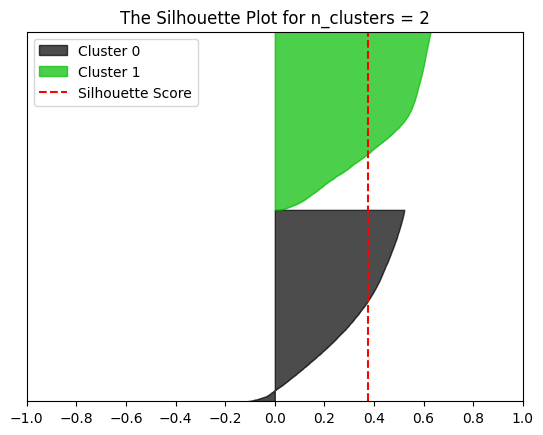

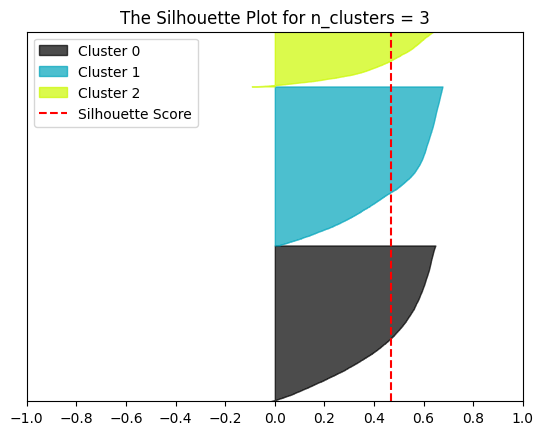

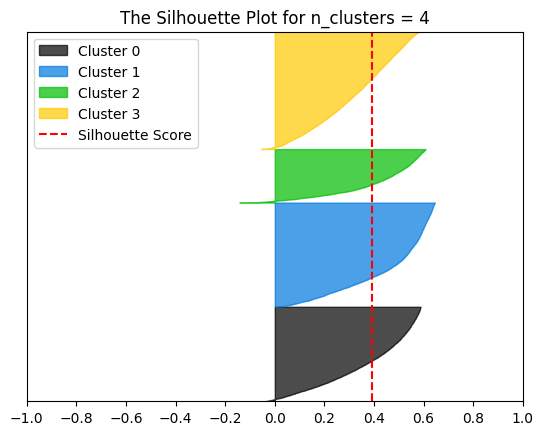

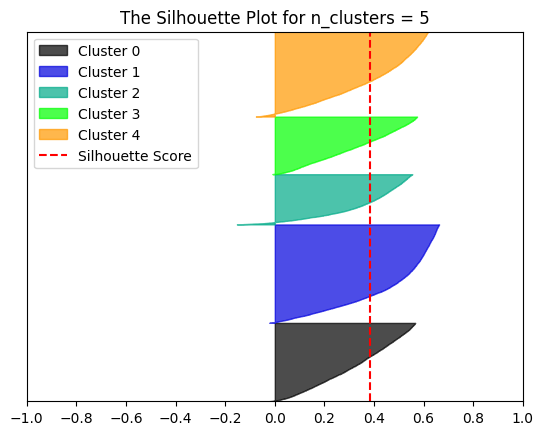

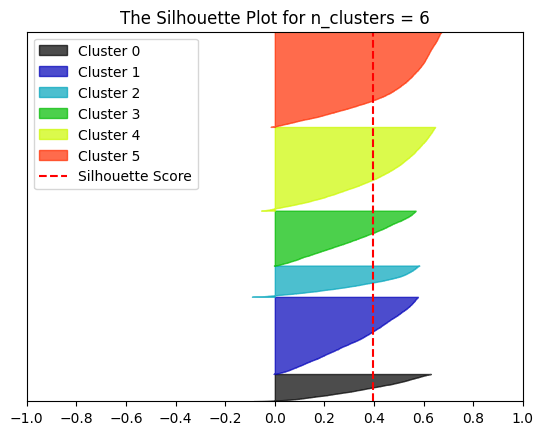

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_silhouette_score (X, n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)
        sil_avg = silhouette_score(X, cluster_labels)
        sil_samples = silhouette_samples(X, cluster_labels)

        plt.xlim([-1, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10]) #to create space from each individual silhouette plot

        plt.yticks([]) # Clear the yaxis labels
        plt.xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sil_samples[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            y_lower = y_upper + 10  # Add space for next cluster

        plt.axvline(x = sil_avg, color="red", linestyle = "--")
        plt.title(f"The Silhouette Plot for n_clusters = {n_clusters}")
        plt.legend([f'Cluster {i}' for i in range(n_clusters)] + [ 'Silhouette Score' ])

        plt.show()



for i in range(2, 7):
    draw_silhouette_score(X, i)



Based on these plots, we can see that the best number of clusters is 3, as it has the highest Silhouette Score

## GMM

[np.float64(0.3962617469225232), np.float64(0.4413493541648489), np.float64(0.36617922823822896), np.float64(0.348044906175335), np.float64(0.367349338088359)]


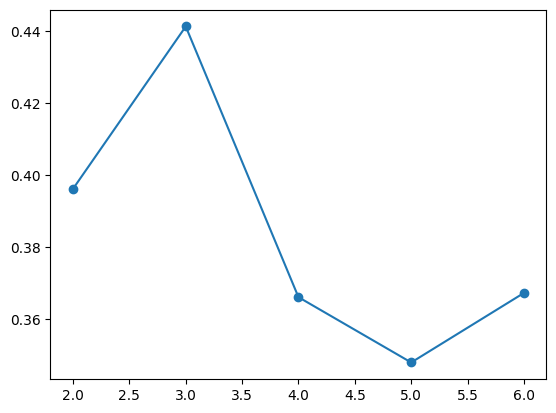

In [22]:
from sklearn.mixture import GaussianMixture
scores = []

num_cluster_range = list(range(2, 7))

for n_clusters in num_cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=69)

    labels = gmm.fit_predict(X)

    scores.append(silhouette_score(X, labels))

plt.plot(num_cluster_range, scores, marker = "o")

print(scores)

We can see that using GMM 3 clusters is also the best number, the scores being roughly the same

## GMM and KMeans Plots

Text(0.5, 1.0, 'GMM')

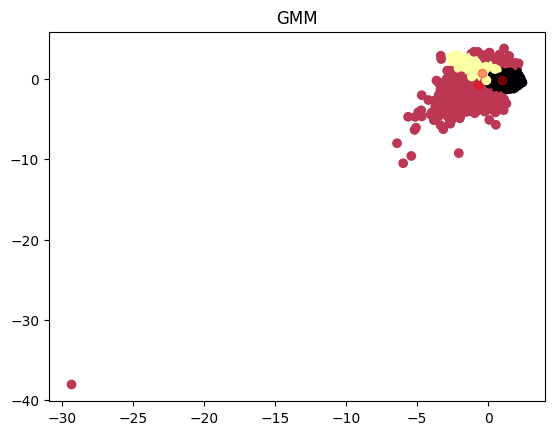

In [77]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

gmm = GaussianMixture(n_components=3, random_state=32)
kmeans = KMeans(n_clusters=3, random_state=32)

gmm_labels = gmm.fit_predict(X)
kmeans_labels = kmeans.fit_predict(X)

gmm_means = gmm.means_
kmeans_centers = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c = gmm_labels, cmap="inferno")
plt.scatter(gmm_means[:, 0], gmm_means[:, 1], c="red", alpha=0.4)
plt.title("GMM")

We can see that GMM doesnt work very well for this data set

Text(0.5, 1.0, 'KMeans')

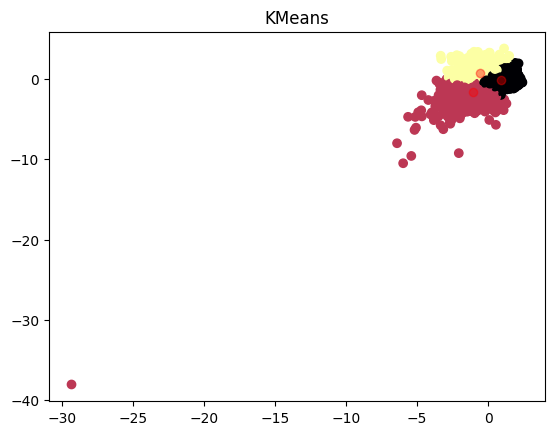

In [78]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap="inferno")
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", alpha=0.4)
plt.title("KMeans")

After applying PCA and sclaing, the results are much more different, and over all beter

KMeans seems to do better with the data, classifying the groups better

In [82]:
gmm_means = pca.inverse_transform(gmm_means) #because we applyed pca and scaling before, we have to undo its effects
gmm_means = scaler.inverse_transform(gmm_means)

kmeans_centers = pca.inverse_transform(kmeans_centers)
kmeans_centers = scaler.inverse_transform(kmeans_centers)

# PCA inverse isnt working, and i cant transform the back t the original dimensionality

pd.DataFrame(data=gmm_means)

,0,1
0,1.665993,0.035206
1,-0.961866,-1.515765
2,-1.015448,0.998357


In [81]:
pd.DataFrame(data=kmeans_centers)


,0,1
0,1.212924,-0.112777
1,-1.176395,-2.175390
2,-0.837869,0.886677
